# EDA and Feature Engineering + Score Testing

### Loading the cleaned CSVs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import time

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train=pd.read_csv('datasets/train_delin.csv')
test=pd.read_csv('datasets/test_delin.csv')

In [3]:
train.head()
train=train.drop('Unnamed: 0',axis=1)

In [4]:
train.shape

(2041, 179)

In [5]:
test=test.drop('Unnamed: 0',axis=1)

In [6]:
test['SalePrice']=np.zeros(shape=test.iloc[:,0].shape)

In [7]:
test.shape

(879, 179)

In [8]:
df=pd.concat([train,test],sort=False)

### Aggregate some columns if the correlation is higher after

In [9]:
bath=train.columns[[('Bath' in x) for x in train.columns]]

In [10]:
def agg(name,listy,df,drop=False):
    aggname=name+'_agg'
    df2=pd.DataFrame(np.zeros(shape=df.iloc[:,0].shape),columns=[aggname])
    for item in listy:
        df2[item]=df[item].values
        df2[aggname]=df2[aggname]+df2[item]
        df2['SalePrice']=df['SalePrice'].values
    print(df2[df2['SalePrice']>0].corr()['SalePrice'].sort_values(ascending=False))
    if drop:
        print (df.shape)
        df.drop(columns=listy,inplace=True)
        df[aggname]=df2[aggname].values
        print (df.shape)
    return df

In [11]:
df=agg('bath',bath,df,drop=True)

SalePrice         1.000000
bath_agg          0.610640
Full Bath         0.537569
Half Bath         0.286387
Bsmt Full Bath    0.282383
Bsmt Half Bath   -0.045062
Name: SalePrice, dtype: float64
(2920, 179)
(2920, 176)


In [12]:
sfs=list([x for x in df.columns if 'SF' in x])

y=['BsmtFin SF 1','Total Bsmt SF','1st Flr SF','Low Qual Fin SF','House Style_SFoyer','>4000SF']
for x in y:
    sfs.remove(x)



In [13]:
df=agg('smallSF',sfs,df,drop=True)

SalePrice          1.000000
smallSF_agg        0.417372
Open Porch SF      0.335435
Wood Deck SF       0.327693
2nd Flr SF         0.250903
Bsmt Unf SF        0.189332
Screen Porch SF    0.135833
3Ssn Porch SF      0.049020
BsmtFin SF 2       0.015022
Name: SalePrice, dtype: float64
(2920, 176)
(2920, 170)


In [14]:
Miscs=list([x for x in df.columns if 'Misc' in x])

y=[]
for x in y:
    sfs.remove(x)

df=agg('misc',Miscs,df,drop=False)

SalePrice            1.000000
Misc Feature_TenC    0.019188
Misc Feature_Elev    0.000697
Misc Val            -0.008478
misc_agg            -0.008492
Misc Feature_Othr   -0.008810
Misc Feature_Gar2   -0.023907
Misc Feature_Shed   -0.047315
Name: SalePrice, dtype: float64


In [15]:
Garage=list([x for x in df.columns if 'Garage' in x])
y=['Garage Area','Garage Yr Blt']
for x in y:
    Garage.remove(x)


Garage

['Garage Finish', 'Garage Qual', 'Garage Type_Out']

In [16]:
df=agg('Garage',Garage,df,drop=True)

SalePrice          1.000000
Garage Finish      0.558690
Garage_agg         0.419579
Garage Qual        0.299392
Garage Type_Out   -0.484529
Name: SalePrice, dtype: float64
(2920, 170)
(2920, 168)


In [17]:
#decided not to update this one

In [18]:
train=df[df['SalePrice']>0]
test=df[df['SalePrice']==0]

In [19]:
#train.to_csv('datasets/train_agged.csv')
#test.to_csv('datasets/test_agged.csv')

# Regression Preprocessing(testing of method)

In [20]:
#get the polynomial features
target = 'SalePrice'
nc = [x for x in train.columns if x != target]

X_train,X_test,y_train,y_test=train_test_split(train[nc],train[target])

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test= ss.transform(X_test)
test=test.drop('SalePrice',axis=1)
test_sc=ss.transform(test)
X=ss.transform(train[nc])
y=train[target]



#pf = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
#X_train_poly=pf.fit_transform(X_train)
#X_test_poly=pf.fit_transform(test)
#X_train_poly.shape

In [21]:
X_train.shape

(1530, 167)

In [22]:
y_train.shape

(1530,)

In [23]:
X_test.shape

(511, 167)

In [24]:
y_test.shape

(511,)

In [25]:
#try naive MLR for a baseline performance


In [26]:
lr=LinearRegression()
model=lr.fit(X_train,y_train)
score=model.score(X_test,y_test)



In [27]:
score

-1.7218516912500704e+23

In [28]:
cross_val_score(lr,X_train,y_train,cv=10).mean()

-4.877677248324688e+24

##### We can see from the cross_val_score that variance is very high. We try lasso to see if we can reduce the complexity and thus variance of the predictions

In [29]:
l_alphas = np.logspace(2, 6, 100)
lasso_model = Lasso(alpha=3000,max_iter=10000000)
#lasso_model = LassoCV(alphas=l_alphas, cv=10,max_iter=100000, fit_intercept=True)
lasso_model = lasso_model.fit(X_train, y_train)

In [30]:
len(test.columns[[(item>0)for column,item in zip(test.columns,lasso_model.coef_)]])

26

In [31]:
lasso_model.alpha

3000

In [32]:
#lasso_model = Lasso(alpha=alpha)

In [33]:
cross_val_score(lasso_model,X_train,y_train,cv=15).mean()

0.8589869161531184

In [34]:
cross_val_score(lasso_model,X_train,y_train,cv=10)

array([0.87553789, 0.85934621, 0.8398401 , 0.85439921, 0.90581762,
       0.88923728, 0.92053611, 0.65930659, 0.90282802, 0.88922532])

In [35]:
lasso_model = lasso_model.fit(X_train,y_train)

In [36]:
train_predictions=lasso_model.predict(X_train)

In [37]:
test_predictions=lasso_model.predict(X_test)

0.8908803690020118

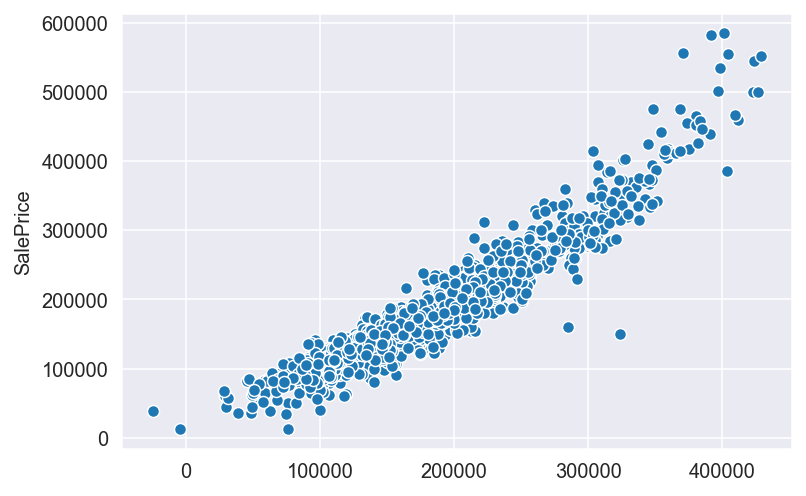

In [38]:
sns.scatterplot(train_predictions,y_train)
lasso_model.score(X_train,y_train)

0.8801111520501834

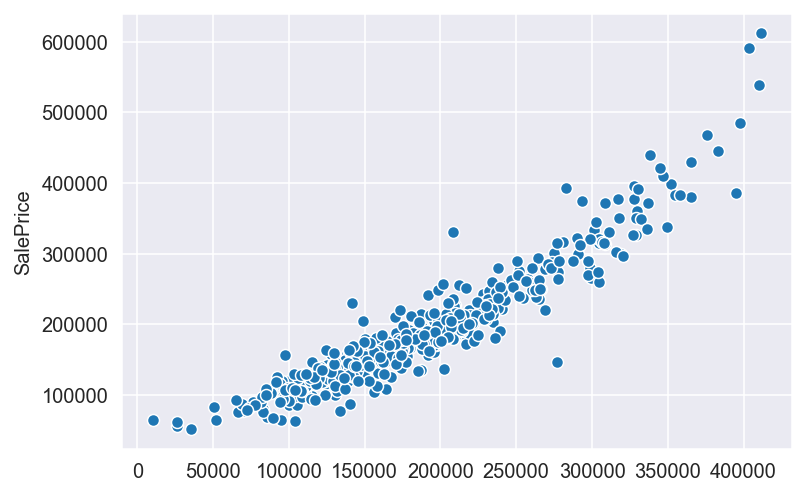

In [39]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_test,y_test)

In [40]:
lasso_model=lasso_model.fit(X,y)

In [41]:
cvs=cross_val_score(lasso_model,X,y,cv=10)
cvs.mean()

0.8570047886245403

In [42]:
lasso_model.intercept_

180555.12953477274

In [43]:
predictions_test=lasso_model.predict(test_sc)

In [44]:
predictions_test.mean()

178855.42160558785

In [45]:
submit=pd.DataFrame()

In [46]:
submit['Id']=test['Id']
submit['SalePrice']=predictions_test
submit=submit.set_index('Id')
submit.to_csv('submit_l1.csv')

In [47]:
submit.describe()

,SalePrice
count,879.000000
mean,178855.421606
std,66960.357343
min,18486.299000
25%,130265.984055
50%,165044.262370
75%,218606.426709
max,436957.554420


In [48]:
submit.shape

(879, 1)

In [49]:
lasso_model.coef_.shape

(167,)

In [50]:
test.shape

(879, 167)

### Using the coefficients of the lasso_model, we find the features that were used in the model and extract them to reduce the complexity of the model, and export for the next iteration

In [51]:
new_columns=test.columns[[(item>0)for column,item in zip(test.columns,lasso_model.coef_)]]

In [52]:
new_columns

Index(['Lot Area', 'Overall Qual', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC', '1st Flr SF',
       'Gr Liv Area', 'Kitchen Qual', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Area', 'Land Contour_HLS',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'Roof Style_Hip', 'Exterior 1st_BrkFace', 'Sale Type_New', 'bath_agg'],
      dtype='object')

In [53]:
new_columns=list(new_columns)

In [54]:
new_columns.append('Id')

In [55]:
len(new_columns)

27

In [56]:
train2=pd.DataFrame(train[new_columns])

In [57]:
test2=pd.DataFrame(test[new_columns])

In [58]:
train2['SalePrice']=train['SalePrice']

In [59]:
#train2.to_csv('datasets/train_lassoed.csv')

In [60]:
#test2.to_csv('datasets/test_lassoed.csv')

In [61]:
train2.shape

(2041, 28)

In [62]:
#train['SalePrice']

In [63]:
#get the polynomial features
target = 'SalePrice'
nc = [x for x in train2.columns if x != target]

X_train,X_test,y_train,y_test=train_test_split(train2[nc],train2[target])

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test= ss.transform(X_test)
#test2=test2.drop('SalePrice',axis=1)
test2_sc=ss.transform(test2)
X=ss.transform(train2[nc])



pf = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
X_train_poly=pf.fit_transform(X_train)
X_test_poly=pf.fit_transform(X_test)
X_train_poly.shape
X_poly=pf.fit_transform(X)
test2_sc_poly=pf.fit_transform(test2_sc)
test_poly_cols=pf.get_feature_names(test2.columns)

In [64]:
X_train.shape

(1530, 27)

In [65]:
X_train_poly.shape

(1530, 378)

In [66]:
test2_sc_poly.shape

(879, 378)

In [67]:
l_alphas = np.logspace(2.5, 6, 100)
lasso_model = Lasso(alpha=9000,max_iter=10000000)
#lasso_model = LassoCV(alphas=l_alphas, cv=10,max_iter=100000, fit_intercept=True)
lasso_model = lasso_model.fit(X_train_poly, y_train)

In [68]:
cross_val_score(lasso_model,X_train_poly,y_train,cv=5).mean()

0.8243572062487579

In [69]:
lasso_model.alpha

9000

In [70]:
len([column for column,item in zip(test_poly_cols,lasso_model.coef_) if (item>0)])

29

In [71]:
test_predictions=lasso_model.predict(X_test_poly)

0.8546092751641579

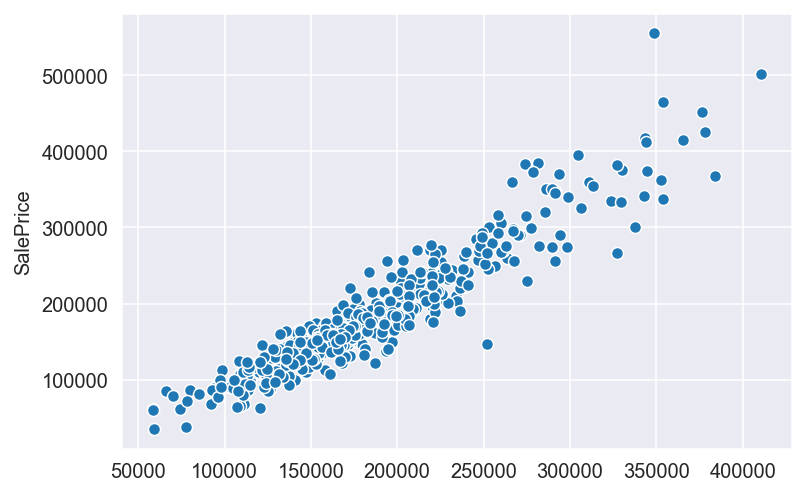

In [72]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_train_poly,y_train)

0.8626296154019703

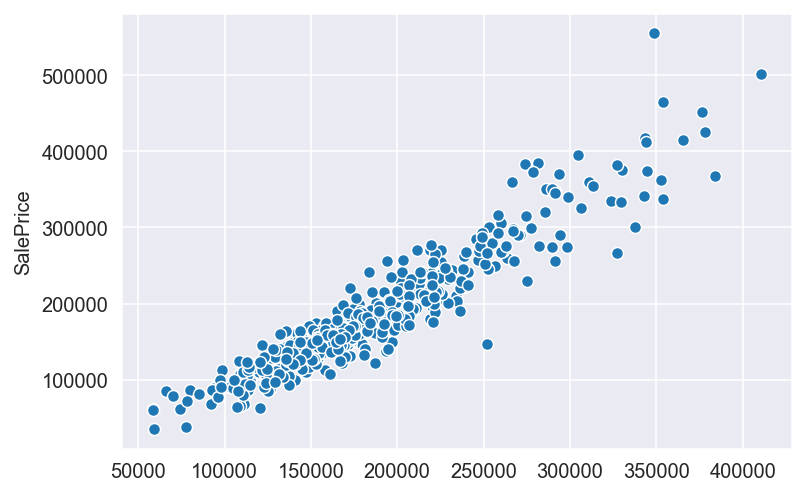

In [73]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_test_poly,y_test)

In [74]:
lasso_model.intercept_

176243.80405147548

In [75]:
pd.set_option('display.max_columns', 100)

In [76]:
predictions_test=lasso_model.predict(test2_sc_poly)

In [77]:
submit['Id']=list(test2['Id'])
submit['SalePrice']=predictions_test
submit=submit.set_index('Id')
submit.to_csv('submissions/dllagg.csv')

In [78]:
submit.head()

,SalePrice
Id,
2658,150278.597510
2718,183307.972788
2414,204170.463118
1989,128851.177142
625,177961.251678


In [79]:
len(lasso_model.coef_)

378

In [80]:
new_columns=[column for column,item in zip(test_poly_cols,lasso_model.coef_) if (item>0)]

In [81]:
len(new_columns)

29

In [82]:
new_train=pd.DataFrame(X_poly,columns=test_poly_cols)
new_train=new_train[new_columns]
new_train['SalePrice']=train['SalePrice']

In [83]:
new_test=pd.DataFrame(test2_sc_poly,columns=test_poly_cols)
new_test=new_test[new_columns]
new_test['SalePrice']=np.zeros(shape=(879,))


In [84]:
new_test.to_csv('datasets/lltest.csv')
new_train.to_csv('datasets/lltest.csv')

#Kaggle  

Private score = 29363.50647  
Public score= 7903.89541
